# EasyEdit Example with **IKE_Baichuan-7B**
The following is a toy experiment utilizing the Baichuan base model, employing the IKE method for LLM knowledge editing.
This tutorial uses `Python3.9`.
## Knowledge Editing

Deployed models may still make unpredictable errors. For example, Large Language Models (LLMs) notoriously *hallucinate*, *perpetuate bias*, and *factually decay*, so we should be able to adjust specific behaviors of pre-trained models.

**Knowledge editing** aims to adjust an initial base model's $(f_\theta)$ behavior on the particular edit descriptor $[x_e, y_e]$, such as:
- $x_e$: "Who is the president of the US?
- $y_e$: "Joe Biden."

efficiently without influencing the model behavior on unrelated samples. The ultimate goal is to create an edited model $(f_{\theta})$.

As the picture follow,the model should edit target facts and facts that are similar in semantic space, without changing irrelevant facts.

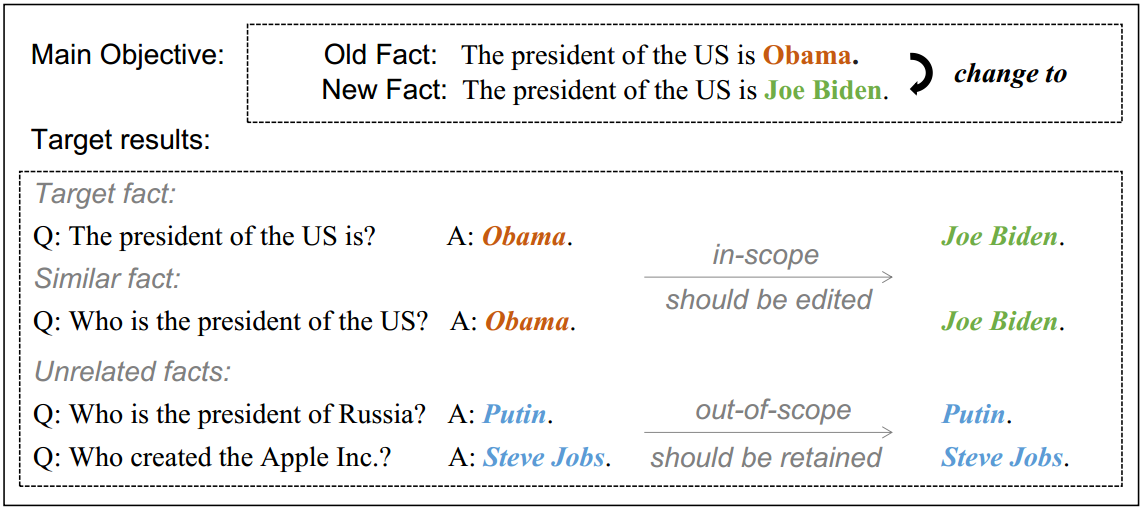

In addition to this, the performance of model editing should be measured from multiple dimensions:

- `Reliability`: the success rate of editing with a given editing description
- `Generalization`: the success rate of editing **within** the editing scope
- `Locality`: whether the model's output changes after editing for unrelated inputs
- `Portability`: the success rate of editing for factual reasoning(one hop, synonym, one-to-one relation)
- `Efficiency`: time and memory consumption required during the editing process


# Method: **IKE**

Paper: [Can We Edit Factual Knowledge by In-Context Learning?](https://arxiv.org/abs/2305.12740)

**IKE** (In-context Knowledge Editing), is a way of editing factual knowledge in large language models **without modifying their parameters**, but by **providing different types of natural language demonstrations** as part of the input.  
It can achieve competitive knowledge editing performance **with less computation overhead and side effects**, as well as better scalability and interpretability.

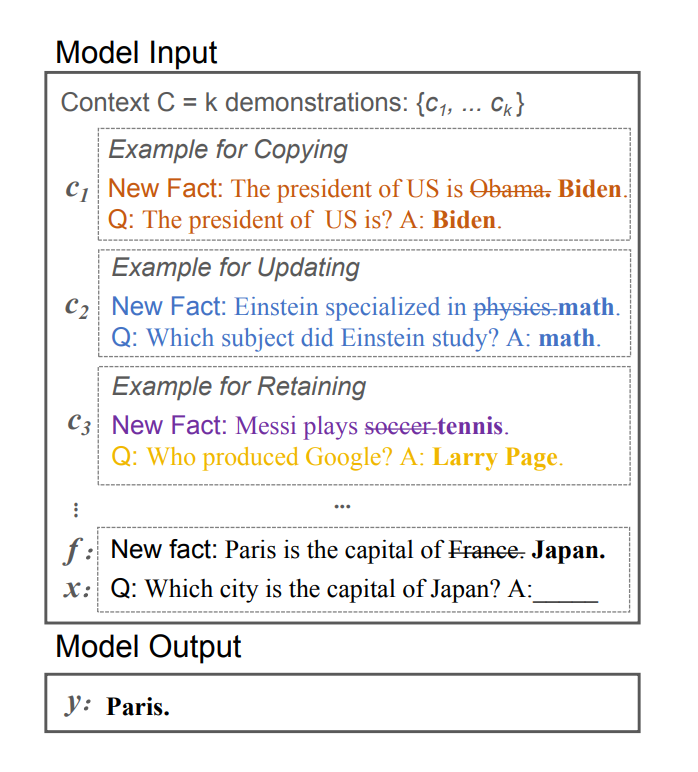

## Prepare the runtime environment

In [ ]:
!git clone https://github.com/zjunlp/EasyEdit
%cd EasyEdit
!ls

In [ ]:
!apt-get install python3.9
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.9 1
!sudo update-alternatives --config python3
!apt-get install python3-pip
!pip install -r requirements.txt
!pip install sentence_transformers

## Download models
Download the Baichuan-7B base model and the all-MiniLM-L6-v2 model from sentence-transformers.

Perhaps you can directly use Hugging Face's cache. 

When you encounter network timeouts, you should download them to your local machine through a mirror site such as [aliendao](https://aliendao.cn/models/baichuan-inc/Baichuan-7B#/)

## Add method configuration file

vim hparams/IKE/baichuan-7b.yaml as follows
```
alg_name: "IKE"
model_name: "./hugging_cache/Baichuan-7B"
sentence_model_name: "./hugging_cache/all-MiniLM-L6-v2"
device: 0
results_dir: "./results"

k: 16
model_parallel: false
```

## Prepare the required editing facts  and context examples

If the current path is in tutorial notes, return to the previous level EasyEdit

In [1]:
!pwd

/mnt/8t/xkw/EasyEdit/tutorial-notebooks


In [1]:
%cd ..

/mnt/8t/xkw/EasyEdit


In [2]:
from easyeditor import BaseEditor
from easyeditor import IKEHyperParams
from easyeditor.models.ike.util import encode_ike_facts
from sentence_transformers import SentenceTransformer

# the fact to be edit
prompts = ['Q: The president of the US is? A:',]
ground_truth = ['Donald Trump']
target_new = ['Joe Biden']
subject = ['president']
rephrase_prompts = ['The leader of the United State is']
# IKE need train_ds(For getting In-Context prompt)
train_ds = [
    {
        'prompt': 'Q: The president of the US is? A:',
        'target_new': 'Joe Biden',
        'rephrase_prompt': 'The leader of the United State is',
        'locality_prompt': 'The president of Russia is ',
        'locality_ground_truth': 'Putin'
    },
    {
        'prompt': 'Einstein specialized in',
        'target_new': 'physics',
        'rephrase_prompt': 'Einstein is good at',
        'locality_prompt': 'Q: Which subject did Newton specialize in? A: ',
        'locality_ground_truth': 'physics'

    },
    # add more if needed

]


## Run the knowledge editor
Construct the editor based on the configuration (model base & editing method used) and the editing facts

In [ ]:
hparams = IKEHyperParams.from_hparams('./hparams/IKE/baichuan-7b.yaml')
editor = BaseEditor.from_hparams(hparams)

# Initialize SentenceTransformer model
sentence_model = SentenceTransformer(hparams.sentence_model_name)
# Generate and save sentence embeddings
encode_ike_facts(sentence_model, train_ds, hparams)

metrics, edited_model, _ = editor.edit(
    prompts=prompts,
    ground_truth=ground_truth,
    rephrase_prompts=rephrase_prompts, # new para
    target_new=target_new,
    subject=subject,
    train_ds=train_ds,
    sequential_edit = True
)

print(metrics)

## Performance Comparison 
Simple comparison of performance with models that do not undergo knowledge editing.

In [ ]:
from transformers import AutoModelForCausalLM
from transformers import AutoTokenizer

tokenizer =AutoTokenizer.from_pretrained('./hugging_cache/Baichuan-7B',trust_remote_code=True)
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side='left'

device = 1
model = AutoModelForCausalLM.from_pretrained('./hugging_cache/Baichuan-7B',trust_remote_code=True).to(f'cuda:{device}')

In [ ]:

ike_generation_prompts = [
    "The sky is red. \
    The color of the sky is red. \
    Q: What is the color of sky? A: Red. \
    Q: What color is the sky? A:",
    "The president of the US is Biden. \
    Q: Who is the president of the US? A: Biden. \
    Biden is the leader of the United State. \
    Q: Who is the president of the US? A:",
]
generation_prompts = [
    "Q: What color is the sky? A:",
    "Q: Who is the president of the US? A:",
]

max_length = 60 
edited_batch = tokenizer(ike_generation_prompts, return_tensors='pt', padding=True, max_length=max_length)
batch = tokenizer(generation_prompts, return_tensors='pt', padding=True, max_length=max_length)

pre_edit_outputs = model.generate(
    input_ids=batch['input_ids'].to(model.device),
    attention_mask=batch['attention_mask'].to(model.device),
    max_new_tokens=15
)
post_edit_outputs = edited_model.generate(
    input_ids=edited_batch['input_ids'].to(edited_model.device),
    attention_mask=edited_batch['attention_mask'].to(edited_model.device),
    max_new_tokens=15
)
print('*'*100)

generation_max_length = batch['input_ids'].shape[-1]
edited_max_length = edited_batch['input_ids'].shape[-1]
for i in range(len(ike_generation_prompts)):
    print(f'Pre-Edit  Output: {tokenizer.decode( pre_edit_outputs[i][generation_max_length :], skip_special_tokens=True)}')
    print(f'Post-Edit Output: {tokenizer.decode(post_edit_outputs[i][edited_max_length :], skip_special_tokens=True)}')
    print('--'*50 )

/mnt/8t/xkw/anaconda3/envs/EasyEdit/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2888: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


****************************************************************************************************
Pre-Edit Outputs:  ['</s></s>Q: What color is the sky? A: Blue.\nB: What color is the sky?\nA: Blue.\nB: What color is the sky?\nA: Blue.\nB: What color is the sky?\nA: Blue.\nB: What', 'Q: Who is the president of the US? A: The president of the US is the head of state and head of government of the United States. The president is the commander-in-chief of the United States Armed Forces. The president is the only elected official in the federal government']
Post-Edit Outputs:  ['</s></s></s></s></s></s></s>The sky is red.     The color of the sky is red.     Q: What is the color of sky? A: Red.     Q: What color is the sky? A: Red.   ', 'The president of the US is Biden.     Q: Who is the president of the US? A: Biden.     Biden is the leader of the United State.     Q: Who is the president of the US? A: Biden.   ']
